This notebook contains many attempts to buil a CNN from scratch to solve the classification task, every experiment is commented, however none of them gave notable results

# Intro

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_datasets as tfds

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast

tfk = tf.keras
tfkl = tf.keras.layers

Dataset Details:

Image size: 96x96

Color space: RGB (read as 'rgb' in ImageDataGenerator.flow_from_directory ('color_mode' attribute) or use PIL.Image.open('imgname.jpg').convert('RGB'))

File Format: JPG

Number of classes: 8

Classes:

0: "Species1"

1: "Species2"

2: "Species3"

3: "Species4"

4: "Species5"

5: "Species6"

6: "Species7"

7: "Species8"

# Data import

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Random seed for reproducibility
seed = 44

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
!ls ../gdrive/MyDrive/datasets/

genres	       ovariancancer_grp.csv  training_dataset_homework1.zip
movielens.csv  ovariancancer_obs.csv
Oracle	       training_data_final


In [ ]:
# Dataset folders 
dataset_dir = '../gdrive/MyDrive/datasets'
dataset_folder = os.path.join(dataset_dir, 'training_data_final')

In [ ]:
"""# Plot example images from dataset
labels = ['Species1',       # 0
          'Species2',           # 1
          'Species3',    # 2
          'Species4',              # 3
          'Species5',          # 4
          'Species6',          # 5
          'Species7',   # 6
          'Species8']        # 7

num_row = 8
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(9*num_row,18*num_col))
for i in range(num_row*num_col):

  class_imgs = next(os.walk('{}/training_data_final/{}/'.format(dataset_dir, labels[i//num_col])))[2]
  class_img = class_imgs[i%num_col]
  img = Image.open('{}/training_data_final/{}/{}'.format(dataset_dir, labels[i//num_col], class_img))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(labels[i//num_col]))

plt.tight_layout()
plt.show()"""

"# Plot example images from dataset\nlabels = ['Species1',       # 0\n          'Species2',           # 1\n          'Species3',    # 2\n          'Species4',              # 3\n          'Species5',          # 4\n          'Species6',          # 5\n          'Species7',   # 6\n          'Species8']        # 7\n\nnum_row = 8\nnum_col = 4\nfig, axes = plt.subplots(num_row, num_col, figsize=(9*num_row,18*num_col))\nfor i in range(num_row*num_col):\n\n  class_imgs = next(os.walk('{}/training_data_final/{}/'.format(dataset_dir, labels[i//num_col])))[2]\n  class_img = class_imgs[i%num_col]\n  img = Image.open('{}/training_data_final/{}/{}'.format(dataset_dir, labels[i//num_col], class_img))\n  ax = axes[i//num_col, i%num_col]\n  ax.imshow(np.array(img))\n  ax.set_title('{}'.format(labels[i//num_col]))\n\nplt.tight_layout()\nplt.show()"

# Split train and validation

## Data generator way

In [ ]:
image_augment = False
val_split = 0.2

"""
Found 3015 images belonging to 8 classes.
Found 527 images belonging to 8 classes."""

'\nFound 3015 images belonging to 8 classes.\nFound 527 images belonging to 8 classes.'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height=96
img_width = 96
batch_size=64

# Instance of ImageDataGenerator with rescalinf and validation split
if image_augment:
  # Create an instance of ImageDataGenerator with Data Augmentation
  all_data_gen = ImageDataGenerator(rotation_range=20,
                                    shear_range=0.2,
                                    height_shift_range=0.1,
                                    width_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True, 
                                    fill_mode='wrap',
                                    rescale=1./255.,
                                    validation_split=val_split)
else:
  all_data_gen = ImageDataGenerator(
      rescale=1./255.,
      validation_split=val_split)

#TODO -> ADD DATA AUGMENTATION

# data generator for train data
train_gen = all_data_gen.flow_from_directory(
    directory=dataset_folder,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    subset='training')

# data generator for validation data
validation_gen = all_data_gen.flow_from_directory(
    directory=dataset_folder,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    subset='validation')

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [ ]:
batch=next(train_gen)  # returns the next batch of images and labels 
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
#plt.imshow(img)   # shows the first image

(256, 96, 96, 3)
(96, 96, 3)


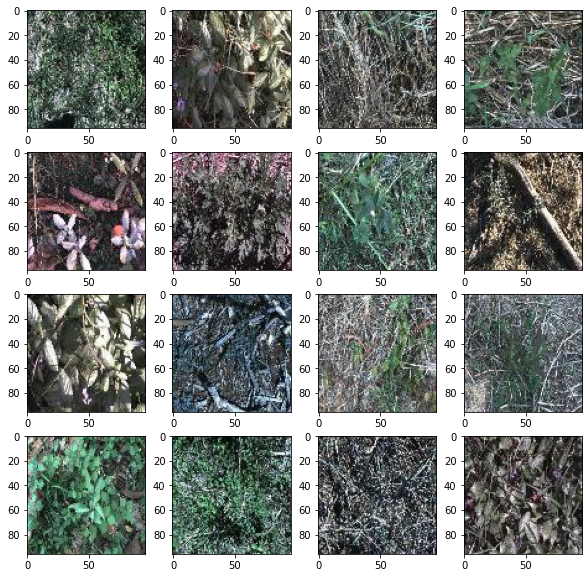

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
ax = axs.flatten()
for i, a in enumerate(ax):
  a.imshow(batch[0][i])

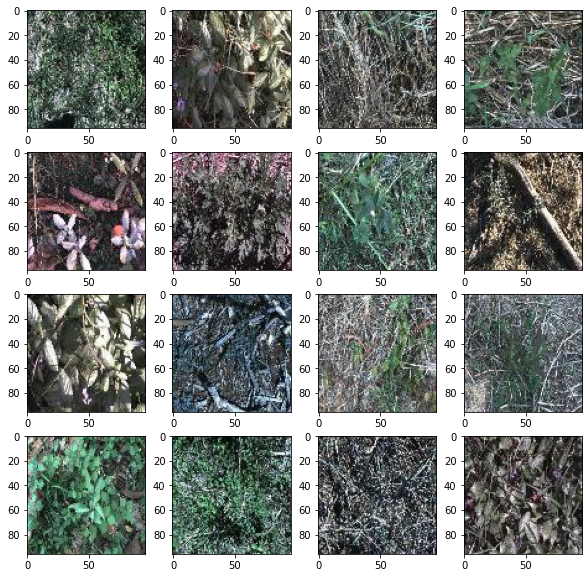

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
ax = axs.flatten()
for i, a in enumerate(ax):
  a.imshow(batch[0][i])

In [ ]:
# print data distribution in train and validation
print("Assigned labels")
print(train_gen.class_indices)
print(validation_gen.class_indices)

class_prob = []

print("\nlabel distribution in train and validation")
for classes in [train_gen.classes, validation_gen.classes]:
  tot_len = classes.shape[0]
  print(f"\ntotal: {tot_len}")
  for i in range(8):
    tmp_count = np.sum(classes == i)
    p = tmp_count/tot_len
    class_prob.append(p)
    print(f"class: {i} -> {tmp_count}\t\t{p:.2f}%")

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

label distribution in train and validation

total: 2836
class: 0 -> 149		0.05%
class: 1 -> 426		0.15%
class: 2 -> 412		0.15%
class: 3 -> 409		0.14%
class: 4 -> 425		0.15%
class: 5 -> 178		0.06%
class: 6 -> 430		0.15%
class: 7 -> 407		0.14%

total: 706
class: 0 -> 37		0.05%
class: 1 -> 106		0.15%
class: 2 -> 103		0.15%
class: 3 -> 102		0.14%
class: 4 -> 106		0.15%
class: 5 -> 44		0.06%
class: 6 -> 107		0.15%
class: 7 -> 101		0.14%


In [ ]:
# build proportional class weights keras accepted format
class_prob = class_prob[:8]
max_p = max(class_prob)
min_p = min(class_prob)
class_weight = {}

for i, p in enumerate(class_prob):
  class_weight[i] = max_p / p

class_weight

{0: 2.885906040268456,
 1: 1.0093896713615023,
 2: 1.0436893203883495,
 3: 1.0513447432762835,
 4: 1.011764705882353,
 5: 2.4157303370786516,
 6: 1.0,
 7: 1.0565110565110565}

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y_label = train_gen.classes
class_weight = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_label),
                                        y = y_label                                                    
                                    )
class_weight = dict(zip(np.unique(y_label), class_weight))
class_weight

In [ ]:
# example function to extract images from generator
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)


  return image, target, batch

In [ ]:
"""# access the batch elements
images, targets, batch = get_next_batch(train_gen)

# explore inside batch
index_to_explore = 0
image = images[index_to_explore]
target = targets[index_to_explore]
target_idx = np.argmax(target)
fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image))
print()
print("Categorical label:", target)
print("Label:", target_idx)
print("Class name:", labels[target_idx])"""

'# access the batch elements\nimages, targets, batch = get_next_batch(train_gen)\n\n# explore inside batch\nindex_to_explore = 0\nimage = images[index_to_explore]\ntarget = targets[index_to_explore]\ntarget_idx = np.argmax(target)\nfig = plt.figure(figsize=(6, 4))\nplt.imshow(np.uint8(image))\nprint()\nprint("Categorical label:", target)\nprint("Label:", target_idx)\nprint("Class name:", labels[target_idx])'

## Keras preprocessing layers for data augmentation

In [ ]:
train_dataset = tfk.utils.image_dataset_from_directory(
    directory=dataset_folder,
    labels="inferred",
    label_mode="categorical",
    color_mode='rgb',
    shuffle=True,
    image_size=(96,96),
    seed=seed,
    validation_split=0.2,
    subset='training'
)

validation_dataset = train_dataset = tfk.utils.image_dataset_from_directory(
    directory=dataset_folder,
    labels="inferred",
    label_mode="categorical",
    color_mode='rgb',
    shuffle=True,
    image_size=(96,96),
    seed=seed,
    validation_split=0.2,
    subset='validation'
)

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']


In [ ]:
plt.figure(figsize=(96/4, 96/4))
for images, labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
# example of to build a preproc layed and applying it
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
data_augmentation = Sequential(
  [
    RandomFlip(input_shape=(img_height,img_width,3)),
    RandomRotation(0.2),
    RandomZoom(0.3)
  ]
)

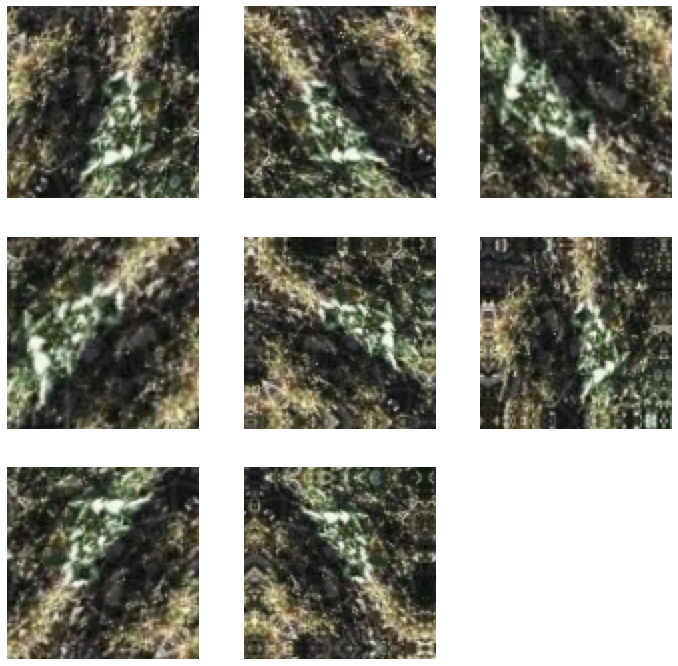

In [ ]:
plt.figure(figsize=(12, 12))
for images, _ in train_dataset.take(1):
  for i in range(8):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Use buffered prefetching so you can yield data from disk without having I/O become blocking

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Model construction

In [ ]:
input_shape = (img_height, img_width, 3)
epochs = 700

## Model 1

overfitting, val accuracy around 0.43, callbaks only early stopping

In [ ]:
model = Sequential()

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(120, activation='relu'))
model.add(Dense(60, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
callbacks_list.append(es_callback)

## Model 2 (model 1 shriked in dense part)
41 accuracy still able to overfit but slowly, the receptive field is not covering the whole image

In [ ]:
model = Sequential()

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
callbacks_list.append(es_callback)

## Model 3 ( model 2 but with augmented receptive field by adding one extra Conv layer of 32 and 64)
in the number of params 300k the model is most similar to model 1, it has the same complexity of model 2 in the dense parte, but reaching total number of params of model 1 with the convolutional part, receptive field reached 104 from 76
notice: the model is too complex in the CNN part, out of 300k params only 184k are for the dense

In [ ]:
model = Sequential()

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
callbacks_list.append(es_callback)

## Model 4 ( from model 3 one max poolin layer moved from end to begginning leaving conv layer to be flattenen, reduction of size 3 convolutions and also blokc with 64 filters reduced to 32, dense layer enlarged 100/40)
150 k params, around 50k for conv, no improvements still not able to go more than 0.44 of val accuracy

In [ ]:
model = Sequential()

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
#model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dense(40, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
callbacks_list.append(es_callback)

## Model 5
change of strategy buil a simple but deeper network

In [ ]:
model = Sequential()

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))


model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dense(40, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
callbacks_list.append(es_callback)

# Model 6
adding dropout made better the accuracy but the model is unable to calssify class 1 and 5. also suffering with 3 and 4

In [ ]:
model = Sequential()

model.add(
    Conv2D(
        filters=4,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=12,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=24,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=30,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=40,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_initializer = tfk.initializers.HeUniform(seed)))


model.add(Flatten())
model.add(Dropout(0.3, seed=seed))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.3,seed=seed))
model.add(Dense(40, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
callbacks_list.append(es_callback)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_190 (Conv2D)         (None, 96, 96, 4)         112       
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 48, 48, 4)        0         
 ng2D)                                                           
                                                                 
 conv2d_191 (Conv2D)         (None, 48, 48, 8)         296       
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 24, 24, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_192 (Conv2D)         (None, 24, 24, 12)        876       
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 12, 12, 12)     

## Model compilation

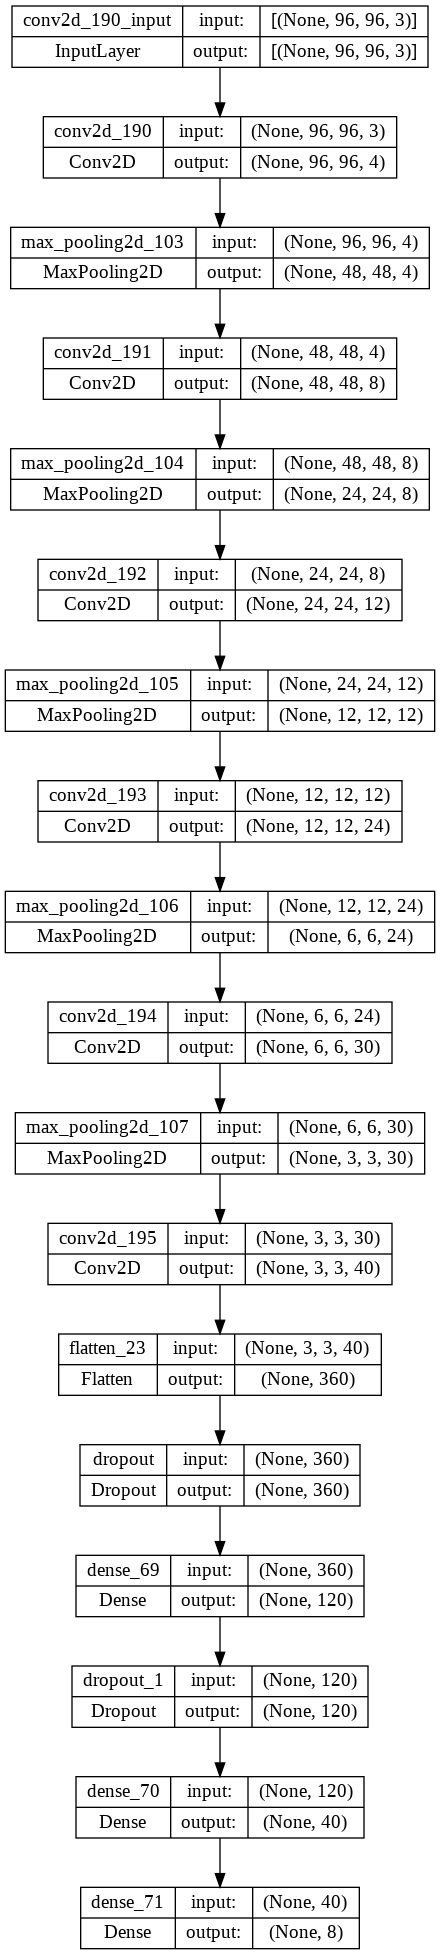

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Model 7 (useless complexity + higher dropout still no l1 or l2 normalization)
little not relevant impovement 0.47, probably nomralization is needed the model is cancelled now this new one with l2 norm.

normalized with l2 = 1e-3 gave 0.57, basically class 1 and 5 never extracted-> trial delivery with all data

In [ ]:
model = Sequential()
l2_lambda = 1e-3

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))


model.add(Flatten())
model.add(Dropout(0.4, seed=seed))
model.add(Dense(350,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.4,seed=seed))
model.add(Dense(100,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
callbacks_list.append(es_callback)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_232 (Conv2D)         (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 48, 48, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_233 (Conv2D)         (None, 48, 48, 16)        1168      
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 24, 24, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_234 (Conv2D)         (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_140 (MaxPooli  (None, 12, 12, 32)     

# Model 8, same as model 7 but with data aumentation = True
DELIVERED

1) behaviour similar to underfitting, very slow learnign and the net look stucked at accuracy 0.33, probably too normalize or too dropout. retried with dropout from 0.4 to 0.2

2) from the begginning it is clear that dropout 0.4 was too high, with 0.2 from the 5th epoch we are already at 0.4 accuracy.
0.62 max accuraqcy but the model was kind undefitting the train accuracy could no go higher as the val accuracy -> add more complexity, reduce learning rate, reduce regularization, the class 1 and 5 are ignored solve this problem

3) thirm experiment run with weight proportion scales of the loss function, gone wrong, model predicting only first class

4) class 1 and 5 predicted but very poor result delivery at 0.47

In [ ]:
model = Sequential()
l2_lambda = 1e-3

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))


model.add(Flatten())
model.add(Dropout(0.2, seed=seed))
model.add(Dense(350,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.2,seed=seed))
model.add(Dense(100,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=17, restore_best_weights=True)
callbacks_list.append(es_callback)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_280 (Conv2D)         (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d_178 (MaxPooli  (None, 48, 48, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_281 (Conv2D)         (None, 48, 48, 16)        1168      
                                                                 
 max_pooling2d_179 (MaxPooli  (None, 24, 24, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_282 (Conv2D)         (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_180 (MaxPooli  (None, 12, 12, 32)     

# Model 9 larger dense layer but just one

still look simple try to enanche feature extraction, get slow at 0.46

In [ ]:
model = Sequential()
l2_lambda = 1e-3

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))


model.add(Flatten())
model.add(Dropout(0.2, seed=seed))
model.add(Dense(520,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.2,seed=seed))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=17, restore_best_weights=True)
callbacks_list.append(es_callback)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_292 (Conv2D)         (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d_188 (MaxPooli  (None, 48, 48, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_293 (Conv2D)         (None, 48, 48, 16)        1168      
                                                                 
 max_pooling2d_189 (MaxPooli  (None, 24, 24, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_294 (Conv2D)         (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_190 (MaxPooli  (None, 12, 12, 32)     

# Model 10

convolution extended, 1.5mln params 0.5mln for cnn, trying to get features, tanh at dense layer

2) made more complex it was like model 11 2mln (0.66 val 0.68 max train)

3) boosted dense, more patience, less regularization (0.55 DELIVERED)

In [ ]:
model = Sequential()
l2_lambda = 1e-4

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))


model.add(Flatten())
model.add(Dropout(0.3, seed=seed))
model.add(Dense(700,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.3,seed=seed))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=35, restore_best_weights=True)
callbacks_list.append(es_callback)

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_346 (Conv2D)         (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_233 (MaxPooli  (None, 48, 48, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_347 (Conv2D)         (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_234 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_348 (Conv2D)         (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_235 (MaxPooli  (None, 12, 12, 64)     

# Model 11 to ran in the night

reduce learning rate, reuse relu in last neurons
(failed)

In [ ]:
model = Sequential()
l2_lambda = 1e-3

model.add(
    Conv2D(
        filters=8,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))


model.add(Flatten())
model.add(Dropout(0.3, seed=seed))
model.add(Dense(520,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.3,seed=seed))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=17, restore_best_weights=True)
callbacks_list.append(es_callback)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_316 (Conv2D)         (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d_208 (MaxPooli  (None, 48, 48, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_317 (Conv2D)         (None, 48, 48, 16)        1168      
                                                                 
 max_pooling2d_209 (MaxPooli  (None, 24, 24, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_318 (Conv2D)         (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_210 (MaxPooli  (None, 12, 12, 32)     

# Model 12, take model 10 and make it more complex and more patince in learning
restore adam learning rate to default, use batch size 64 and weights classes from scikit learn

still looks underfitting, training accuracy stops around 0.64 and keep oscillating

In [ ]:
model = Sequential()
l2_lambda = 1e-4

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dropout(0.3, seed=seed))
model.add(Dense(1000,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.3,seed=seed))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)
callbacks_list.append(es_callback)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_276 (Conv2D)         (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_192 (MaxPooli  (None, 48, 48, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_277 (Conv2D)         (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_193 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_278 (Conv2D)         (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_194 (MaxPooli  (None, 12, 12, 64)     

# Model 13 increase again complexity

from previus expreiment we need to be able to classify classes 3 4 5 better there is too much confusion 2 possible solutions: features more relavant, more separation in the dense part (4 mln params)

1) this model tries to increase complexity of the last part with an high dropout leaving convolutional part non ddropped out (failed dropout 0.5 reduce it)

2) dropout to 0.3, very slow from 0.4 acuracy, extremly slow at 0.6, again behavior like undefitting or convergenge problems of the algorithm
very good results in confusion matrix, it messes up class 1 and 7 completely

3)added batch normalization and went to 5mln params ( bacyh norm and dropout bad idea)

4) lowered dropout to 0.1, again very slow try to remove batch norm maybe could work with higher lerning rate, stopped at epoch 20

5) dropout and 5mln model

In [ ]:
model = Sequential()
l2_lambda = 1e-4

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(1700,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.4,seed=seed))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../gdrive/MyDrive/experiments/tb_logs', 
                                            profile_batch=0,
                                            histogram_freq=1)  # if > 0 (epochs) shows weights histograms
callbacks_list.append(tb_callback)
callbacks_list.append(es_callback)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_263 (Conv2D)         (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_182 (MaxPooli  (None, 48, 48, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_264 (Conv2D)         (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_265 (Conv2D)         (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_184 (MaxPooli  (None, 12, 12, 64)     

# Model 14
double complexity need to debug why we have so slow convergence, is because complex task? missing features? weak separator? "we don't have the complexity to overfit"

1) suspended, not fitting, reduced double layer 
2) suspended, discovered that data gen was overwriting the batch size, retry old models

In [ ]:
model = Sequential()
l2_lambda = 1e-4

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=512,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(2000,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.3,seed=seed))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../gdrive/MyDrive/experiments/tb_logs', 
                                            profile_batch=0,
                                            histogram_freq=1)  # if > 0 (epochs) shows weights histograms
callbacks_list.append(tb_callback)
callbacks_list.append(es_callback)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_258 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_177 (MaxPooli  (None, 48, 48, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_259 (Conv2D)         (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_178 (MaxPooli  (None, 24, 24, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_260 (Conv2D)         (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_179 (MaxPooli  (None, 12, 12, 128)    

# Model 15
1) 5.5 mln model with enanched batch size correctly, it stopped at 0.7 accuracy still not overfitting

2) reduced dropout to 0.2 , selu in last dense layer, l2 to 1e-5, overfitting

3) set l2 to 5e-5, dropout 0.2 and 0.3 (overfit)

4) set l2 to 1e-4, dropout 0.2 and 0.3 (overfit)

5) batch size 64 (overfitting)

6) enanche dropout 0.4 (overfitting)

In [ ]:
model = Sequential()
l2_lambda = 1e-4

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.4,seed=seed))
model.add(Dense(2000,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='selu'))
model.add(Dropout(0.4,seed=seed))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../gdrive/MyDrive/experiments/tb_logs', 
                                            profile_batch=0,
                                            histogram_freq=1)  # if > 0 (epochs) shows weights histograms
callbacks_list.append(tb_callback)
callbacks_list.append(es_callback)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 12, 12, 64)     

# Model 16
from now used keras preprocessing layers

In [ ]:
model = Sequential()
l2_lambda = 1e-4

model.add(Rescaling(1./255, input_shape=(96,96, 3)))

model.add(
    Conv2D(
        filters=16,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=128,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(
    Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3), 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        kernel_initializer = tfk.initializers.HeUniform(seed)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(1900,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='relu'))
model.add(Dropout(0.25,seed=seed))
model.add(Dense(8, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))

model.summary()

# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=22, restore_best_weights=True)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../gdrive/MyDrive/experiments/tb_logs', 
                                            profile_batch=0,
                                            histogram_freq=1)  # if > 0 (epochs) shows weights histograms
callbacks_list.append(tb_callback)
callbacks_list.append(es_callback)

# Model Train

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tfk.losses.CategoricalCrossentropy(), 
    metrics='accuracy'
    )

In [ ]:
# notice if you use the train generator you don't need to specify y
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = validation_gen,
    callbacks = callbacks_list,
    batch_size=256,
    class_weight=class_weight
).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


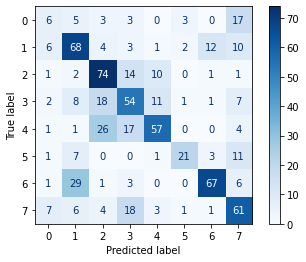

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# model = tfk.models.load_model("../gdrive/MyDrive/experiments/CNN10_3_fold")

Y_pred = model.predict_generator(validation_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_test=validation_gen.classes

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Save best epoch model
model.save("../gdrive/MyDrive/experiments/CNN15_6fold")

In [ ]:
# example delivery
import os
import tensorflow as tf
model_name = 'SubmissionModel'

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, model_name))

    def predict(self, X):
        
        # Insert your preprocessing here

        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)

        return out

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive
